# Healthcare RSI Statistical significance
## Null Hypothesis 1 - The RSI of the heathcare fund, XLV, is the same as the RSI for the S&P 500
## Alternative Hypothesis 1 - The RSI of the heathcare fund, XLV, is different from the RSI for the S&P 500

In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from statsmodels.stats.power import zt_ind_solve_power

key_alphavantage = '9HXBL1MHLXSUW3XP'
function = 'RSI'
interval = 'daily'

In [2]:
symbol1 = 'XLV'

response = requests.get(f'https://www.alphavantage.co/query?function={function}&symbol={symbol1}&interval={interval}&time_period=10&series_type=open&apikey={key_alphavantage}')
response = response.json()

In [3]:
symbol2 = '.INX'

response2 = requests.get(f'https://www.alphavantage.co/query?function={function}&symbol={symbol2}&interval=daily&time_period=10&series_type=open&apikey={key_alphavantage}')
response2 = response2.json()

In [4]:
xlv_dates= list(response[f'Technical Analysis: {function}'].keys())
xlv_dates = xlv_dates[1:]

In [5]:
sp500_dates = list(response2[f'Technical Analysis: {function}'].keys())
sp500_dates = sp500_dates[1:]

In [6]:
xlv_dates_rsi = {}

count = 0
for i in xlv_dates:
    rsi = response[f'Technical Analysis: {function}'][i][f'{function}']
    count += 1
    xlv_dates_rsi[f'{i}'] = float(rsi)

In [7]:
sp500_dates_rsi = {}

count2 = 0 
for i in sp500_dates:
    rsi2 = response2[f'Technical Analysis: {function}'][i][f'{function}']
    count2 += 1
    sp500_dates_rsi[f'{i}'] = float(rsi2)

In [8]:
xlvdf = pd.DataFrame(xlv_dates_rsi.items(), columns = ['date', f'{function}'])

In [9]:
sp500df = pd.DataFrame(sp500_dates_rsi.items(), columns = ['date', f'{function}'])

In [10]:
year = [int(xlv_dates[i].split('-')[0]) for i in range(len(xlv_dates))]
month = [int(xlv_dates[i].split('-')[1]) for i in range(len(xlv_dates))]
day = [int(xlv_dates[i].split('-')[2]) for i in range(len(xlv_dates))]

In [11]:
year2 = [int(sp500_dates[i].split('-')[0]) for i in range(len(sp500_dates))]
month2 = [int(sp500_dates[i].split('-')[1]) for i in range(len(sp500_dates))]
day2 = [int(sp500_dates[i].split('-')[2]) for i in range(len(sp500_dates))]

In [12]:
xlvdf['year'] = year
xlvdf['month'] = month
xlvdf['day'] = day

In [13]:
sp500df['year'] = year2
sp500df['month'] = month2
sp500df['day'] = day2

In [14]:
xlvdf = xlvdf.loc[xlvdf['year'] >= 2017]
sp500df = sp500df.loc[sp500df['year'] >= 2017]

## Comparing the normalized RSI data for XLV and S&P500 

### 2017 Through 2019 YTD


In [15]:
xlv_sample_means = []
sp500_sample_means = []
for i in range(10000):
    xlv_sample = xlvdf.sample(n=50, random_state=i) 
    xlv_sample_means.append(xlv_sample.RSI.mean()) 
        
    sp500_sample = sp500df.sample(n=50, random_state=i) 
    sp500_sample_means.append(sp500_sample.RSI.mean()) 

### Evaluating z - score and statistical significance

In [16]:
xlv_bar = xlvdf.RSI.mean()  ### xlv population mean (subset)
sp500_bar = sp500df.RSI.mean() ### S&P500 population mean (universal population)

sp500_stan_dev = np.std(sp500df.RSI) ### S&P500 population standard dev
sp500_stan_err = sp500_stan_dev/np.sqrt(len(sp500df))
xlv_z_score = (xlv_bar - sp500_bar) / (sp500_stan_dev/np.sqrt(len(sp500df)))

print(f'The z_score is: {xlv_z_score}')
xlv_p_val = stats.norm.cdf(xlv_z_score)

print(f'The p-value is: {xlv_p_val}')
print(f'The standard deviation is {sp500_stan_dev}')
print(f'The standard error is {sp500_stan_err}')   ### Z_score * Standard error = real difference between sample and pop means

The z_score is: -3.5532242921711
The p-value is: 0.0001902699297316012
The standard deviation is 14.47839017477702
The standard error is 0.5315184245640511


### Plotting Histogram Visual 

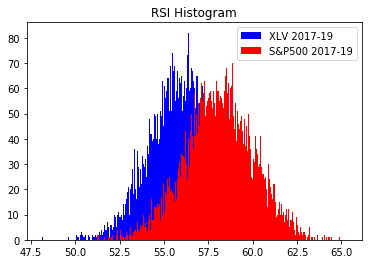

In [17]:
plt.hist(xlv_sample_means, bins=500, color = 'blue', label='XLV 2017-19');
plt.hist(sp500_sample_means, bins=500, color = 'red', label='S&P500 2017-19');
plt.title('RSI Histogram')
plt.legend();

## Cohen's D and Power - How significant is the Difference?

In [18]:
def cohen_d(xlv, sp500):

    diff_mean = xlv.mean() - sp500.mean()

    n_xlv = len(xlv)
    n_sp500 = len(sp500)
    var_xlv = xlv.var()
    var_sp500 = sp500.var()

    pooled_var = (n_xlv * var_xlv + n_sp500 * var_sp500) / (n_xlv + n_sp500)

    cod = diff_mean / np.sqrt(pooled_var)

    return cod

In [19]:
xlv_cod = cohen_d(xlvdf['RSI'], sp500df['RSI'])

In [20]:
n1_xlv = len(xlvdf['RSI'])
n2_sp500 = len(sp500df['RSI'])
ratio = n1_xlv/n2_sp500
xlv_power = zt_ind_solve_power(effect_size = xlv_cod, nobs1=n1_xlv, power = None, alpha = .05) 
print(f'Power= {xlv_power}\nCohen D= {xlv_cod}')

Power= 0.7145397019706381
Cohen D= -0.1311771083823407


In [21]:
xlvdf['RSI'].mean() - sp500df['RSI'].mean()

-1.8886041778974985

It can be inferred that there is a difference, but since power is less than .8, it is less significant. This can be attributed to the small Cohen's D value, meaning there is a small effect on different populations

### Null Hypothesis 2 - The RSI of Johnson & Johnson, the largest holdings in the XLV, mirrors the RSI of the XLV
### Alternative Hypothesis 2 - The RSI of Johnson & Johnson, the largest holdings in the XLV, is different from the RSI of the XLV

In [22]:
symbol_list = ['JNJ'] 

In [23]:
all_list = []
for symbol in symbol_list:
    response = requests.get(f'https://www.alphavantage.co/query?function={function}&symbol={symbol}&interval={interval}&time_period=10&series_type=open&apikey={key_alphavantage}')
    jason = response.json()
    all_list.append(jason)

In [24]:
dictjnj = {}

len_jnj = len(all_list[0]['Technical Analysis: RSI'])
for i in range(len_jnj):
    date = list(all_list[0]['Technical Analysis: RSI'].keys())[i]
    rsi = float(list(all_list[0]['Technical Analysis: RSI'].values())[i]['RSI'])
    dictjnj[f'{date}'] = rsi
df_jnj = pd.DataFrame(dictjnj.items(), columns = ['date', 'rsi'])

year = []
for i in range(len_jnj):
    year.append(int(df_jnj['date'][i].split('-')[0]))

In [25]:
df_jnj['year'] = year
df_jnj.drop(0, inplace = True)

In [26]:
df_jnj = df_jnj.loc[df_jnj['year'] >= 2017] #2017 and newer data

In [27]:
jnj_sample_means = []

for i in range(10000):
    jnj_sample = df_jnj.sample(n=50, random_state=i) 
    jnj_sample_means.append(jnj_sample.rsi.mean()) 

In [28]:
jnj_bar= df_jnj.rsi.mean()  ### johnson and johnson population mean (subset)

xlv_stan_dev = np.std(xlvdf.RSI)
xlv_stan_err = xlv_stan_dev/np.sqrt(len(xlvdf))

jnj_z_score = (jnj_bar - xlv_bar) / (xlv_stan_dev/np.sqrt(len(xlvdf)))
jnj_p_val = stats.norm.cdf(jnj_z_score)
p_valjnj = stats.norm.cdf(jnj_z_score)

print(f'The z_score is: {jnj_z_score}')
print(f'The p-value is: {jnj_p_val}')
print(f'The standard deviation is {xlv_stan_dev}')
print(f'The standard error is {xlv_stan_err}')

The z_score is: -4.917611908104116
The p-value is: 4.3803188163740013e-07
The standard deviation is 14.29634588522281
The standard error is 0.524835368449615


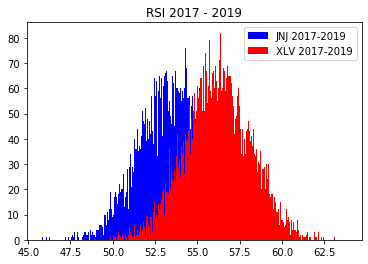

In [29]:
plt.hist(jnj_sample_means, bins=500, color='blue', label='JNJ 2017-2019');
plt.hist(xlv_sample_means, bins=500, color='red', label='XLV 2017-2019');
plt.title('RSI 2017 - 2019')
plt.legend();

In [30]:
print(jnj_z_score * xlv_stan_err)
print(jnj_bar - xlv_bar)

-2.580936657682038
-2.580936657682038


### Cohen's D for Johnson & Johnson and XLV - 2017-2019

In [33]:
codjnj = cohen_d(df_jnj['rsi'], xlvdf['RSI'])

In [34]:
n1_jnj = len(df_jnj['rsi'])
n2_xlv = len(xlvdf['RSI'])
ratio = n1_jnj/n2_xlv
jnj_power = zt_ind_solve_power(effect_size = codjnj, nobs1=n1_jnj, power = None, alpha = .05) 
print(f'Power= {jnj_power}\nCohen D= {codjnj}')

Power= 0.9337192026462193
Cohen D= -0.17984402456369059


In contrast to the prior power analysis, the power is greater than .8, in spite of the relativly small Cohen's D. Meaning that there is a decisive difference in the two groups, although the effect size is small.